In [1]:
import librosa, librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 「MIR-02_2」音频特征小全之时域特征

> 时域特征(temporal feature)就好比描述音频波形的指标，可以说没有比它更直观的特征了。

**♬ 本文为MIR音乐信息检索系列的第2.2篇文章 ♬**

**♬ 该文与上篇2.1概览及后续2.X文章共同组成音频特征小全 ♬**

本文将主要讲解以下时域特征及其简单应用：
- 如何从ADSR包络中观察不同乐器声音的生老停死？
- 如何用过零率找到动次打次中“打”的地方？
- 如何用自相关算法识别单音音高？

---

### 『ADSR包络』

前文2.1概览的最后，我们计算了一帧帧下均方根能量的值，从而得出音频中能量随时间变化的曲线。这个能量曲线就是我们要说的包络(envelope)，每个乐器发出一个单音得到的包络都有所不同，而这些“不同”可以反映在包络的ADSR四个区域里，分别为起音(attack)、衰减(decay)、延音(sustain)和释音(release)。

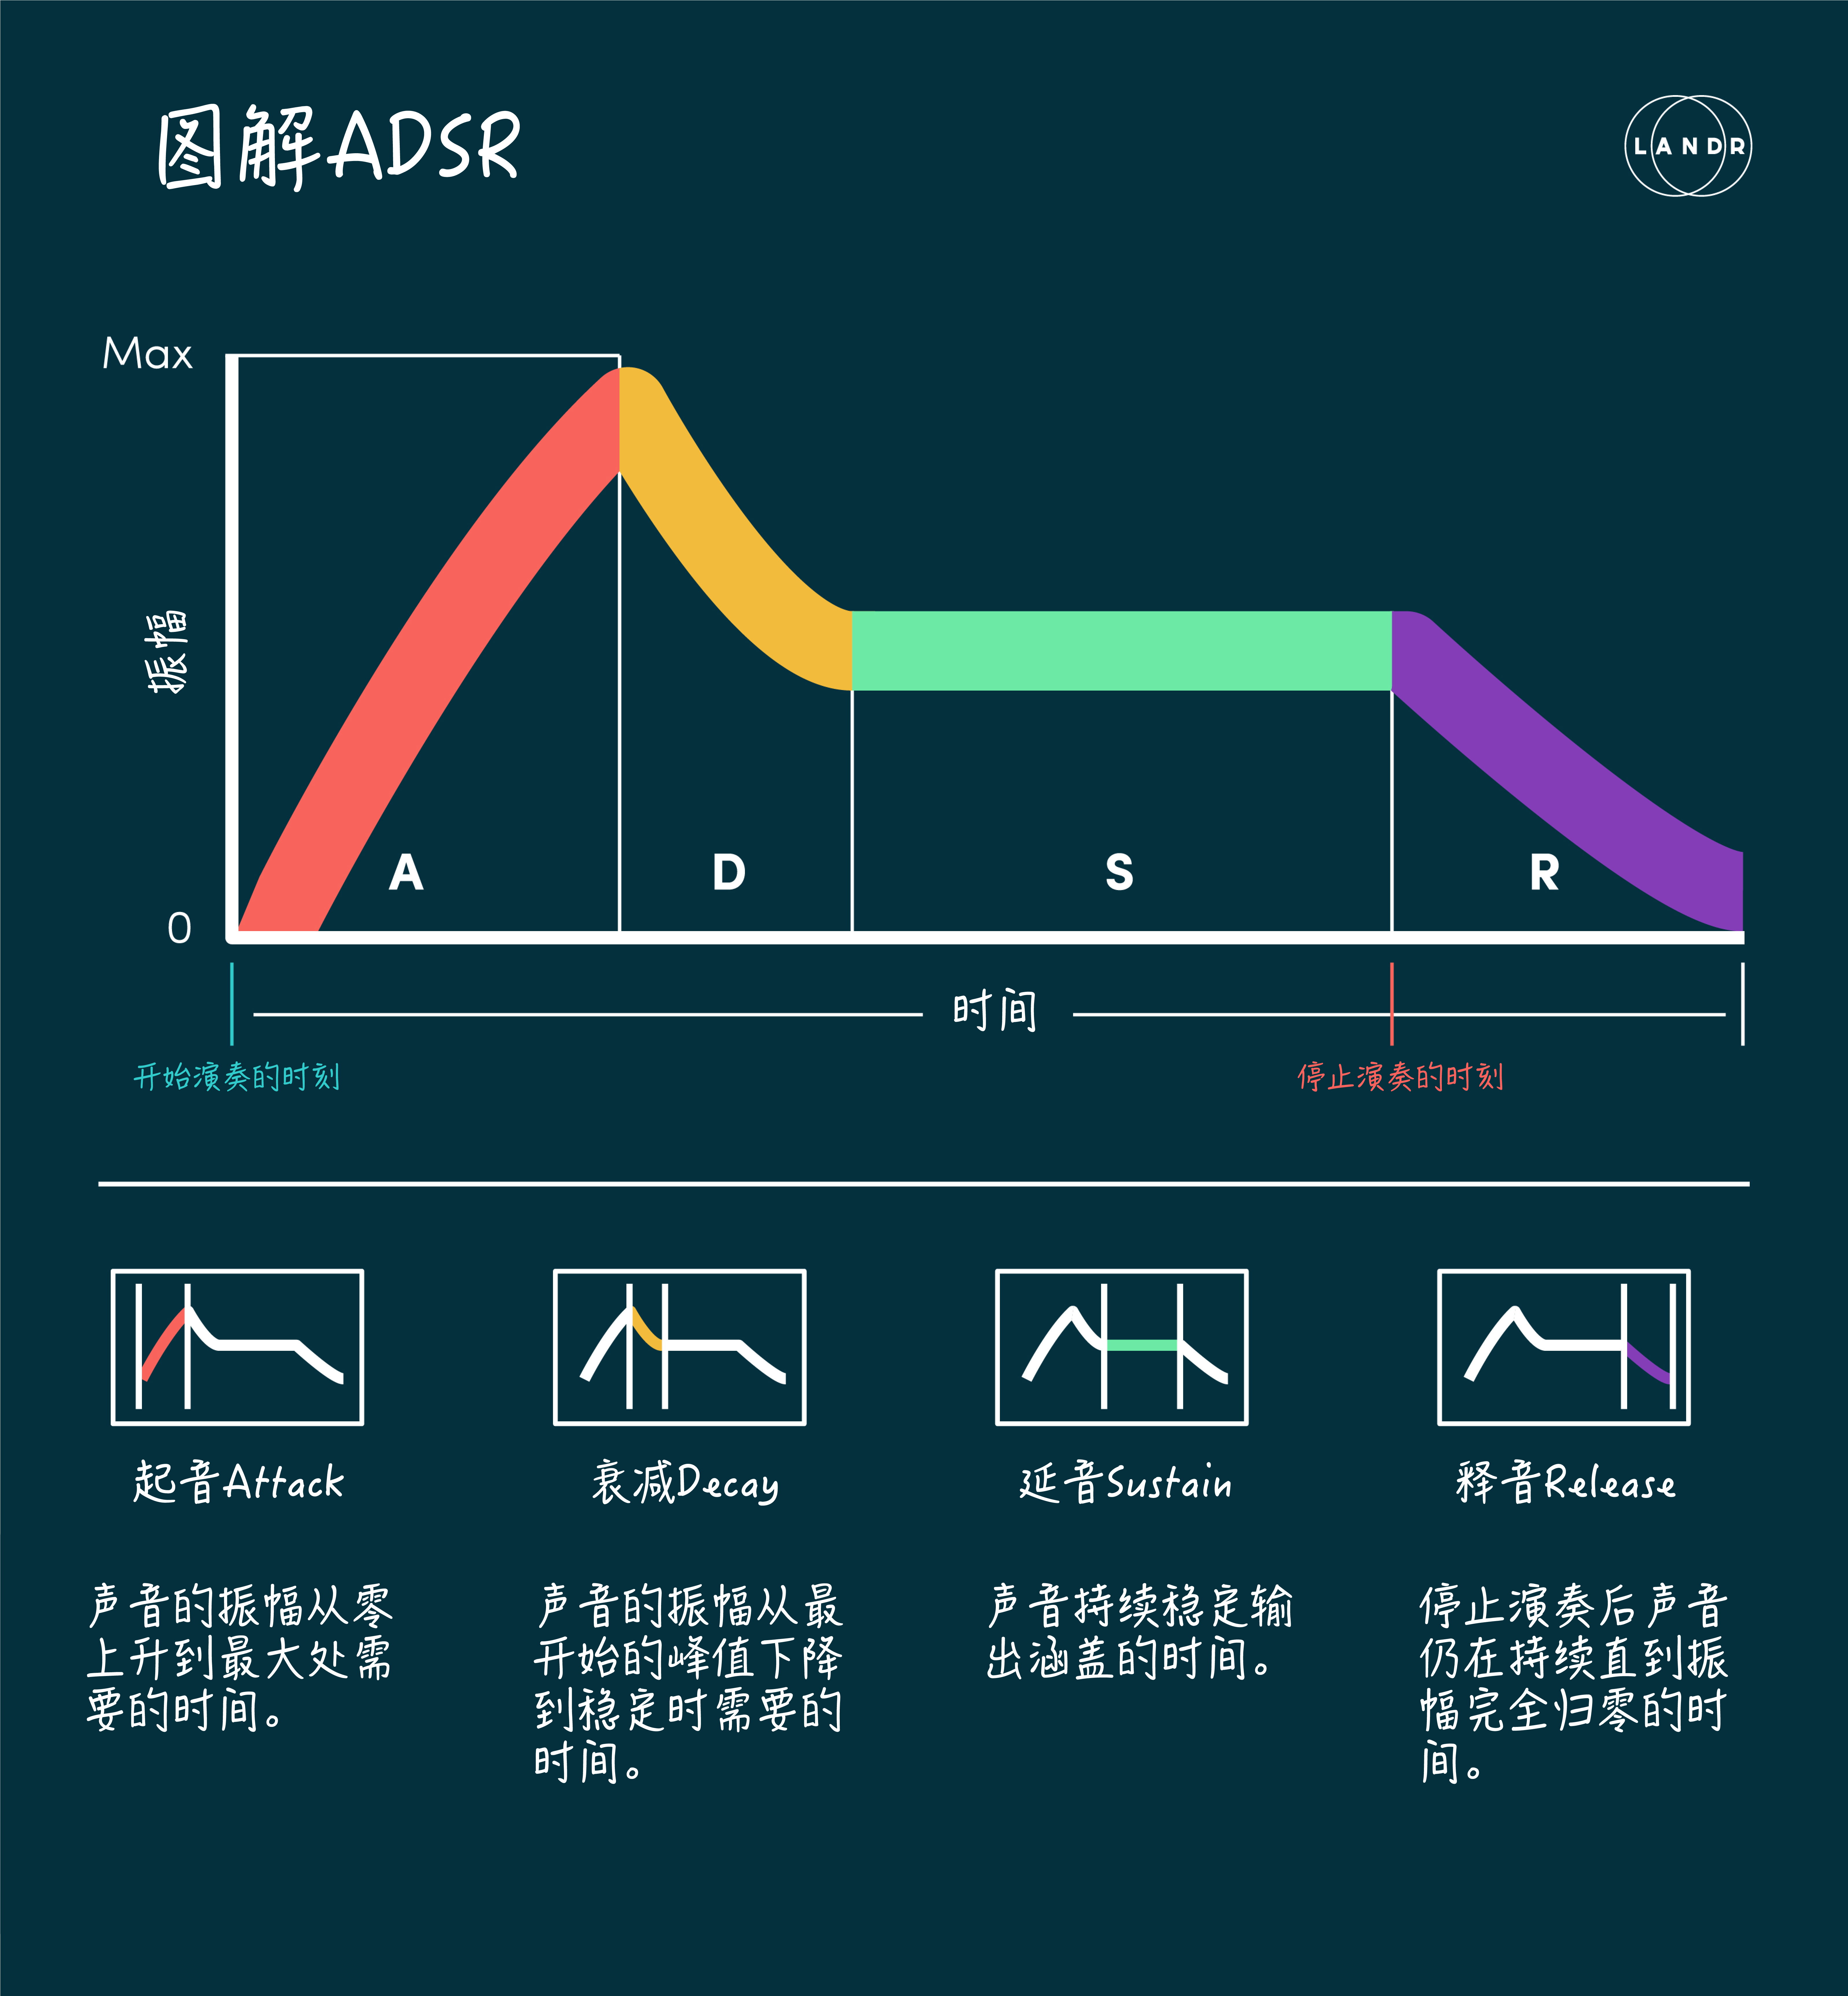

In [2]:
ipd.Image("attachment/mir02-adsr.png")

✎ 一般击弦乐器和打击类乐器的起音都很短，起音之后也不会再有其他机械能的输入因此也不会有延音的阶段，而管弦乐器的延音部分就会很长。下图简单描画了一些乐器的包络。

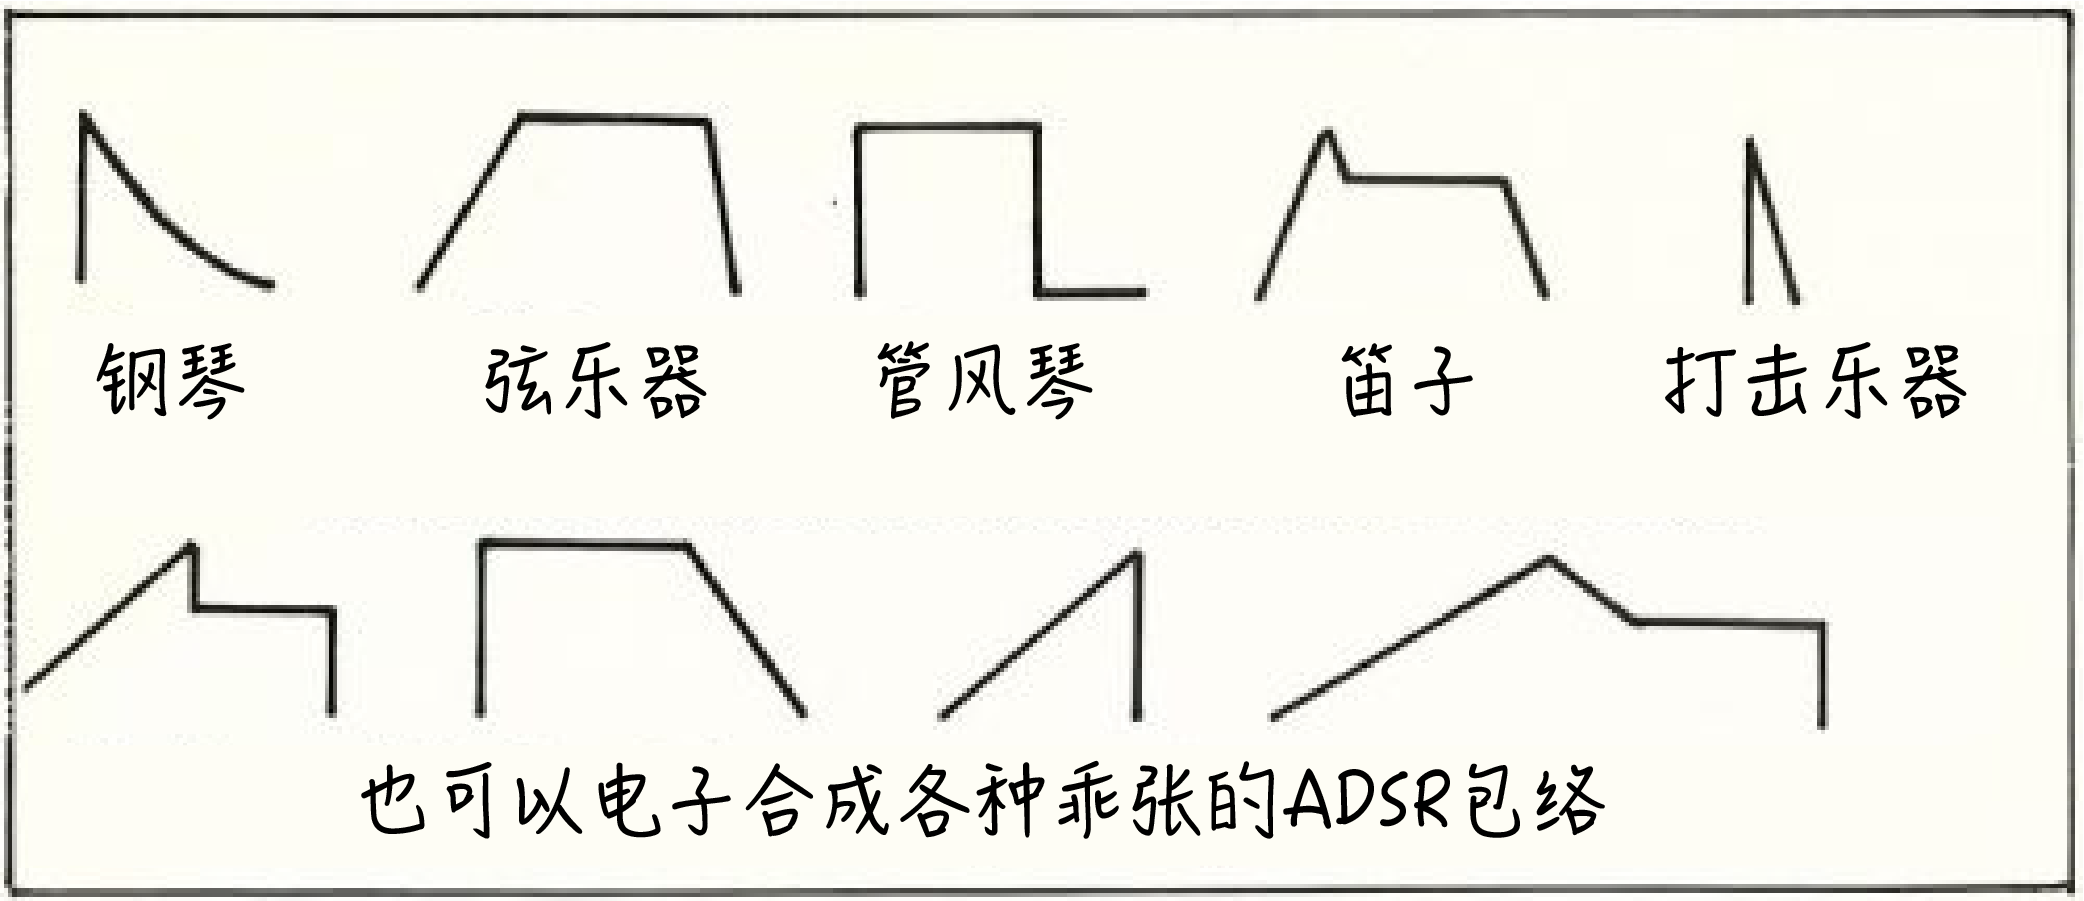

In [3]:
ipd.Image("attachment/mir02-instrument-adsr.png")

✎ 包络的差异是帮助我们理解“不同乐器有不同音色”的助手之一，但其他助手们主要集中在频域特征里。

---

### 『过零率ZCR』

直接从字面意思上理解，过零率(zero-crossing rate)就是指波形在单位时间内的穿零次数。我们用下方的“动打动动打”音乐片段为例仔细了解下ZCR。

In [4]:
dongda, sr = librosa.load('attachment/mir02-dongda.wav')
ipd.Audio(dongda, rate=sr)

以采样率`sr`加载的音频文件，可得到`len(dongda)=49613`个样本，把它们的数值沿时间轴画出来就得到该音频的波形：

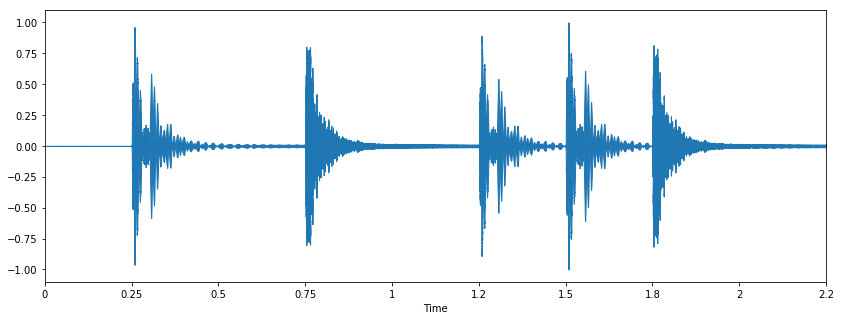

In [5]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(dongda, sr=sr)

假设我们手上有个放大器，现在仔细观察下第6500到7500个之间1000个样本的波形变化：

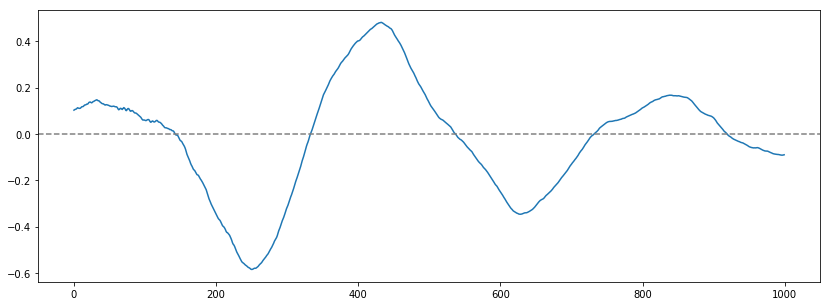

In [6]:
n0 = 6500
n1 = 7500
plt.figure(figsize=(14, 5))
plt.plot(dongda[n0:n1])
plt.axhline(0,linestyle='dashed',color='grey')

可以直接从上图观察到该波形穿过界限0一共有5次，也可以用代码计算次数：

In [7]:
zero_crossings = librosa.zero_crossings(dongda[n0:n1], pad=False)

得到的`zero_crossings`是一个由`True`或`False`组成的长度同样为1000的向量，`True`表示的是在该位置上的输入样本发生了“过零”，因此若计算过零总次数只需要进行一下求和操作：

In [8]:
sum(zero_crossings)

5

针对于整个音频数据，以2048个样本为一帧，计算该帧下过零率，再跳过512个样本继续计算下一帧内的过零率：

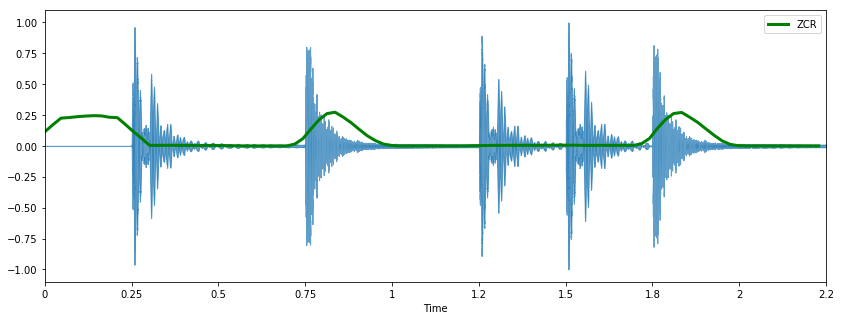

In [10]:
zcrs_init = librosa.feature.zero_crossing_rate(dongda)

# 画出音频波形和每一帧下的过零率
plt.figure(figsize=(14, 5))
zcrs_times = librosa.frames_to_time(np.arange(len(zcrs_init[0])), sr=sr, hop_length=512)
librosa.display.waveplot(dongda, sr=sr, alpha=0.7)
plt.plot(zcrs_times,zcrs_init[0], label='ZCR', lw=3, color='green')
plt.legend()

✎ 我们会发现过零率高的区域恰巧对应了该“动打动动打”音频中“打”的部分，其实“动”是底鼓而“打”是小鼓的声音，底鼓声音的频率较低所以也听上去非常沉稳，而小鼓频率较高听上去“精神多了”，声音的频率高则其在单位时间内拥有更多波形周期，因此单位时间内过零数会更多，那么过零率就更高。

✎ 音频最开始的“无声”区域，其实是有许多非常小数值的样本在界限0的周围转悠，所以也得到了较高的过零率。我们可以先给整个音频样本的数值都加个小小的常数，消除这些小数值对过零率计算的影响：

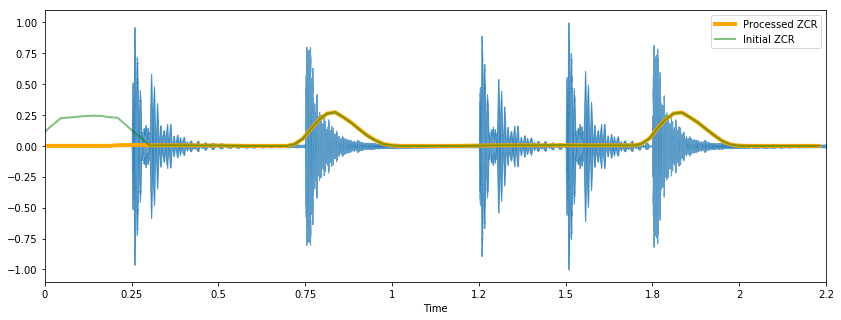

In [11]:
zcrs = librosa.feature.zero_crossing_rate(dongda + 0.0001)

# 画出音频波形和每一帧的过零率（绿线）vs处理后得到的过零率（橙线）
plt.figure(figsize=(14, 5))
zcrs_times = librosa.frames_to_time(np.arange(len(zcrs[0])), sr=sr, hop_length=512)
librosa.display.waveplot(dongda, sr=sr, alpha=0.7)
plt.plot(zcrs_times,zcrs[0], label='Processed ZCR', lw=4, color='orange')
plt.plot(zcrs_times,zcrs_init[0], label='Initial ZCR', lw=2, alpha=0.5, color='green')
plt.legend()

---

### 『自相关』

自相关(autocorrelation)也叫序列相关，可以描述一个信号与其沿时间轴位移后的版本之间的相似度。

$$ r(k) = \sum_n x(n) x(n-k) $$

公式中的`k`是时移参数(lag)，很明显当`k=0`时得到的`r`值最大，也就是信号与信号本身相似度是最大的。

假设该信号是一个周期信号，则该信号与“移动了一个周期长度的该信号”之间的自相关也会返回一个峰值，因此可以估计出周期信号的频率。

可见自相关是一种找出重复模式的数学工具，在MIR领域中可用自相关算法估计乐曲的节奏型，也可以估计单旋律音乐中的基频，著名的YIN算法第一步就是自相关！
 
☞ YIN算法的论文出处：

De Cheveigné, Alain, and Hideki Kawahara. "YIN, a fundamental frequency estimator for speech and music." The Journal of the Acoustical Society of America 111.4 (2002): 1917-1930.

✎ 我们就用双簧管吹奏的1秒音频为输入，用自相关简单实现下如何估计音频里基频：

In [12]:
oboe_data, sr = librosa.load('attachment/mir02-oboe_C6_1046Hz.wav')
ipd.Audio(oboe_data, rate=sr)

假设已知音频中的音高在A0到C8之间即基频范围在：

In [13]:
f_low = 27.5
f_high = 4186.01

则对应的最小与最大k为：

In [14]:
k_high = sr/f_low
k_low = sr/f_high

在此条件下计算其自相关，且不考虑`k_high`以上的时移，并将得到的自相关中小于`k_low`的部分置零：

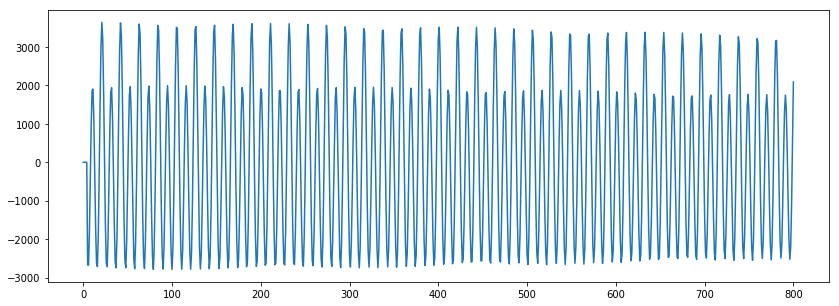

In [15]:
r = librosa.autocorrelate(oboe_data, max_size=int(k_high))
r[:int(k_low)] = 0

# 画出自相关结果
plt.figure(figsize=(14, 5))
plt.plot(r)

✎ 在以上结果中取纵轴数值最大处对应的横轴k的值，即为基频对应的时移参数：

In [16]:
k_fundamental = r.argmax()
print(k_fundamental)

21


✎ 则基频为：

In [17]:
print("{} Hz".format(sr/k_fundamental))

1050.0 Hz


✎ 事实上音频中双簧管吹奏的音高是C6（midi数值为84），其基频为：

In [18]:
print("{} Hz".format(librosa.midi_to_hz(84)))

1046.5022612023945 Hz


可见与我们用自相关估计出的基频还是很接近的！

不过当音频是复调音乐，即同一时刻不止会有一个音被演奏，用自相关估计基频/音高就有些力不从心了`_(:3 」∠ )_`